In [1]:
!pip install dtreeviz
!pip install -U imbalanced-learn

     |████████████████████████████████| 215kB 19.4MB/s 
     |████████████████████████████████| 22.3MB 1.4MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [33]:

%matplotlib inline
#importing libraries
import numpy as np
import scipy.stats
import scipy.special
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import ParameterGrid
from keras.models import Sequential
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape
from keras.layers import Concatenate
from keras.layers.embeddings import Embedding
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
import pickle
import csv
import collections
from datetime import datetime
from sklearn import preprocessing
from keras.callbacks import ModelCheckpoint
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
import seaborn as sns
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer
from sklearn.metrics import plot_confusion_matrix
import math
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import graphviz
from dtreeviz.trees import dtreeviz

from sklearn.calibration import calibration_curve

from itertools import product
from collections import OrderedDict

# **Defining two functions that are used to get a report of our datasets**

In [3]:
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )
def tbl_report(tbl, cols=None, card=10):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    nulls = []
    uniques = []
    numuniques = []
    vcs = []
    for col in dtypes.index:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        #if strdtcol == 'object' or strdtcol[0:3] == 'int' or strdtcol[0:3] == 'int':
        #print(strdtcol)
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card: # low cardinality
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join(["{}:{}".format(k,v) for k, v in valcounts.items()])
        else:
            vc='HC' # high cardinality
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return pretty_print(df[cols])
    return pretty_print(df)

# **Loading and Reading Datasets**

In [4]:
from google.colab import files
files.upload() #upload kaggle.json

TypeError: ignored

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle kernels list — user Sakzsee — sort-by dateRun

!kaggle competitions download -c higgs-boson

!unzip -q train.csv.zip -d .
!unzip -q test.csv.zip -d .
!ls

In [5]:
#Loading train set and loading test set
train = pd.read_csv("training.zip")
test = pd.read_csv("test.zip")

#EventID is identifier - making it an index in both the sets
train.set_index('EventId',inplace = True)
test.set_index('EventId',inplace=True)

In [6]:
#Looking at top 5 rows in train
train.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
EventId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.2,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,0.879,1.414,-999.0,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,3.776,1.414,-999.0,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,2.354,-1.285,-999.0,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,1.056,-1.385,-999.0,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [7]:
#Looking at training set info 
tbl_report(train, cols=['dtype', 'nulls', 'num_uniques', 'value_counts'])

Table Shape (250000, 32)


,dtype,nulls,num_uniques,value_counts
DER_mass_MMC,float64,0,108338,HC
DER_mass_transverse_met_lep,float64,0,101637,HC
DER_mass_vis,float64,0,100558,HC
DER_pt_h,float64,0,115563,HC
DER_deltaeta_jet_jet,float64,0,7087,HC
DER_mass_jet_jet,float64,0,68366,HC
DER_prodeta_jet_jet,float64,0,16593,HC
DER_deltar_tau_lep,float64,0,4692,HC
DER_pt_tot,float64,0,59042,HC
DER_sum_pt,float64,0,156098,HC


In [8]:
#Looking at the numerical descriptions
train.describe()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,-49.023079,49.239819,81.181982,57.895962,-708.420675,-601.237051,-709.356603,2.373100,18.917332,158.432217,1.437609,-0.128305,-708.985189,38.707419,-0.010973,-0.008171,46.660207,-0.019507,0.043543,41.717235,-0.010119,209.797178,0.979176,-348.329567,-399.254314,-399.259788,-692.381204,-709.121609,-709.118631,73.064591,1.646767
std,406.345647,35.344886,40.828691,63.655682,454.480565,657.972302,453.019877,0.782911,22.273494,115.706115,0.844743,1.193585,453.596721,22.412081,1.214079,1.816763,22.064922,1.264982,1.816611,32.894693,1.812223,126.499506,0.977426,532.962789,489.338286,489.333883,479.875496,453.384624,453.389017,98.015662,1.875103
min,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,46.104000,0.047000,-1.414000,-999.000000,20.000000,-2.499000,-3.142000,26.000000,-2.505000,-3.142000,0.109000,-3.142000,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.001502
25%,78.100750,19.241000,59.388750,14.068750,-999.000000,-999.000000,-999.000000,1.810000,2.841000,77.550000,0.883000,-1.371000,-999.000000,24.591750,-0.925000,-1.575000,32.375000,-1.014000,-1.522000,21.398000,-1.575000,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.018636
50%,105.012000,46.524000,73.752000,38.467500,-999.000000,-999.000000,-999.000000,2.491500,12.315500,120.664500,1.280000,-0.356000,-999.000000,31.804000,-0.023000,-0.033000,40.516000,-0.045000,0.086000,34.802000,-0.024000,179.739000,1.000000,38.960000,-1.872000,-2.093000,-999.000000,-999.000000,-999.000000,40.512500,1.156188
75%,130.606250,73.598000,92.259000,79.169000,0.490000,83.446000,-4.593000,2.961000,27.591000,200.478250,1.777000,1.225000,0.000000,45.017000,0.898000,1.565000,53.390000,0.959000,1.618000,51.895000,1.561000,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-2.457000,-2.275000,109.933750,2.404128
max,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,1852.462000,19.773000,1.414000,1.000000,764.408000,2.497000,3.142000,560.271000,2.503000,3.142000,2842.617000,3.142000,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000,7.822543


In [9]:
#Looking at top 5 rows in test
test.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
EventId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
350000,-999.000,79.589,23.916,3.036,-999.000,-999.000,-999.000,0.903,3.036,56.018,1.536,-1.404,-999.000,22.088,-0.540,-0.609,33.930,-0.504,-1.511,48.509,2.022,98.556,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000
350001,106.398,67.490,87.949,49.994,-999.000,-999.000,-999.000,2.048,2.679,132.865,1.777,-1.204,-999.000,30.716,-1.784,3.054,54.574,-0.169,1.795,21.093,-1.138,176.251,1,47.575,-0.553,-0.849,-999.000,-999.000,-999.000,47.575
350002,117.794,56.226,96.358,4.137,-999.000,-999.000,-999.000,2.755,4.137,97.600,1.096,-1.408,-999.000,46.564,-0.298,3.079,51.036,-0.548,0.336,19.461,-1.868,111.505,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
350003,135.861,30.604,97.288,9.104,-999.000,-999.000,-999.000,2.811,9.104,94.112,0.819,-1.382,-999.000,51.741,0.388,-1.408,42.371,-0.295,2.148,25.131,1.172,164.707,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
350004,74.159,82.772,58.731,89.646,1.347,536.663,-0.339,1.028,77.213,721.552,1.713,-0.913,0.004,45.087,-1.548,1.877,77.252,-1.913,2.838,22.200,-0.231,869.614,3,254.085,-1.013,-0.334,185.857,0.335,2.587,599.213


In [10]:
#Looking at test info
tbl_report(test, cols=['dtype', 'nulls', 'num_uniques', 'value_counts'])

Table Shape (550000, 30)


,dtype,nulls,num_uniques,value_counts
DER_mass_MMC,float64,0,152743,HC
DER_mass_transverse_met_lep,float64,0,123271,HC
DER_mass_vis,float64,0,134982,HC
DER_pt_h,float64,0,165204,HC
DER_deltaeta_jet_jet,float64,0,7487,HC
DER_mass_jet_jet,float64,0,140826,HC
DER_prodeta_jet_jet,float64,0,20258,HC
DER_deltar_tau_lep,float64,0,4900,HC
DER_pt_tot,float64,0,76134,HC
DER_sum_pt,float64,0,241132,HC


In [11]:
#Looking at statistical description of test
test.describe()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000
mean,-48.950144,49.261093,81.123904,57.824801,-707.448878,-599.705905,-708.391425,2.374076,18.988277,158.659749,1.439415,-0.126942,-708.015756,38.696831,-0.011861,-0.015815,46.714062,-0.018781,0.051797,41.627231,-0.008214,209.933695,0.980171,-348.946684,-399.883839,-399.896234,-691.309277,-708.150605,-708.153058,73.248856
std,406.233686,35.425422,40.435560,63.291314,454.928791,659.129589,453.461222,0.779895,21.767376,116.237589,0.845026,1.194503,454.043330,22.421603,1.213344,1.816023,22.174519,1.264147,1.814055,32.324457,1.812777,126.910079,0.979271,533.155176,489.467786,489.457747,480.435230,453.834190,453.830095,98.467134
min,-999.000000,0.000000,6.810000,0.000000,-999.000000,-999.000000,-999.000000,0.237000,0.000000,46.103000,0.055000,-1.414000,-999.000000,20.000000,-2.499000,-3.142000,26.000000,-2.508000,-3.142000,0.051000,-3.142000,13.847000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-0.000000
25%,78.167750,19.313000,59.422000,14.192000,-999.000000,-999.000000,-999.000000,1.815000,2.838000,77.471000,0.886000,-1.371000,-999.000000,24.582000,-0.926000,-1.588000,32.378000,-1.011000,-1.508000,21.374000,-1.574000,122.984750,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
50%,105.076000,46.455500,73.747000,38.469500,-999.000000,-999.000000,-999.000000,2.492000,12.390000,120.701500,1.282000,-0.356000,-999.000000,31.770000,-0.021000,-0.042000,40.561500,-0.038000,0.097000,34.758000,-0.017000,179.949000,1.000000,38.970000,-1.862000,-2.111000,-999.000000,-999.000000,-999.000000,40.503500
75%,130.769000,73.646000,92.173000,79.234250,0.503000,84.266250,-4.538000,2.962000,27.649000,201.018000,1.779000,1.230000,0.000000,44.883000,0.899000,1.557000,53.387000,0.956000,1.617000,51.922000,1.558000,263.917250,2.000000,75.499000,0.431000,0.484000,33.832000,-2.429000,-2.260000,110.507000
max,1949.261000,968.669000,1264.965000,1337.187000,8.724000,4794.827000,17.294000,5.751000,759.363000,2079.162000,32.228000,1.414000,1.000000,627.023000,2.500000,3.142000,701.328000,2.506000,3.142000,1254.363000,3.142000,2190.275000,3.000000,1163.439000,4.500000,3.142000,817.801000,4.500000,3.142000,1860.175000


In [12]:
train.shape, test.shape

((250000, 32), (550000, 30))

# **Exploratory Data Analysis**


In [13]:
#Splitting into X and y
X = train.drop(['Label','Weight'], axis = 1)
y = pd.factorize(train['Label'])[0]
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

Shape of X: (250000, 30)
Shape of y: (250000,)


## Let us look at the Class Ratio in our dataset.

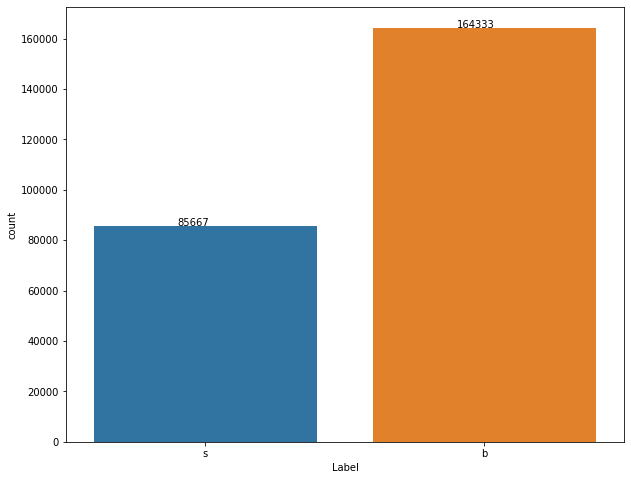

In [14]:
#Let's see the count of each class in our label
plt.figure(figsize=(10,8))
ax = sns.countplot(train['Label']);
for p in ax.patches:
        ax.annotate('{:d}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+5));

Looks like we do indeed have an imbalanced dataset. Considering this, accuracy would not be a good metric of performance. F1 score would be a better fit.

## Finding distribution of each Feature

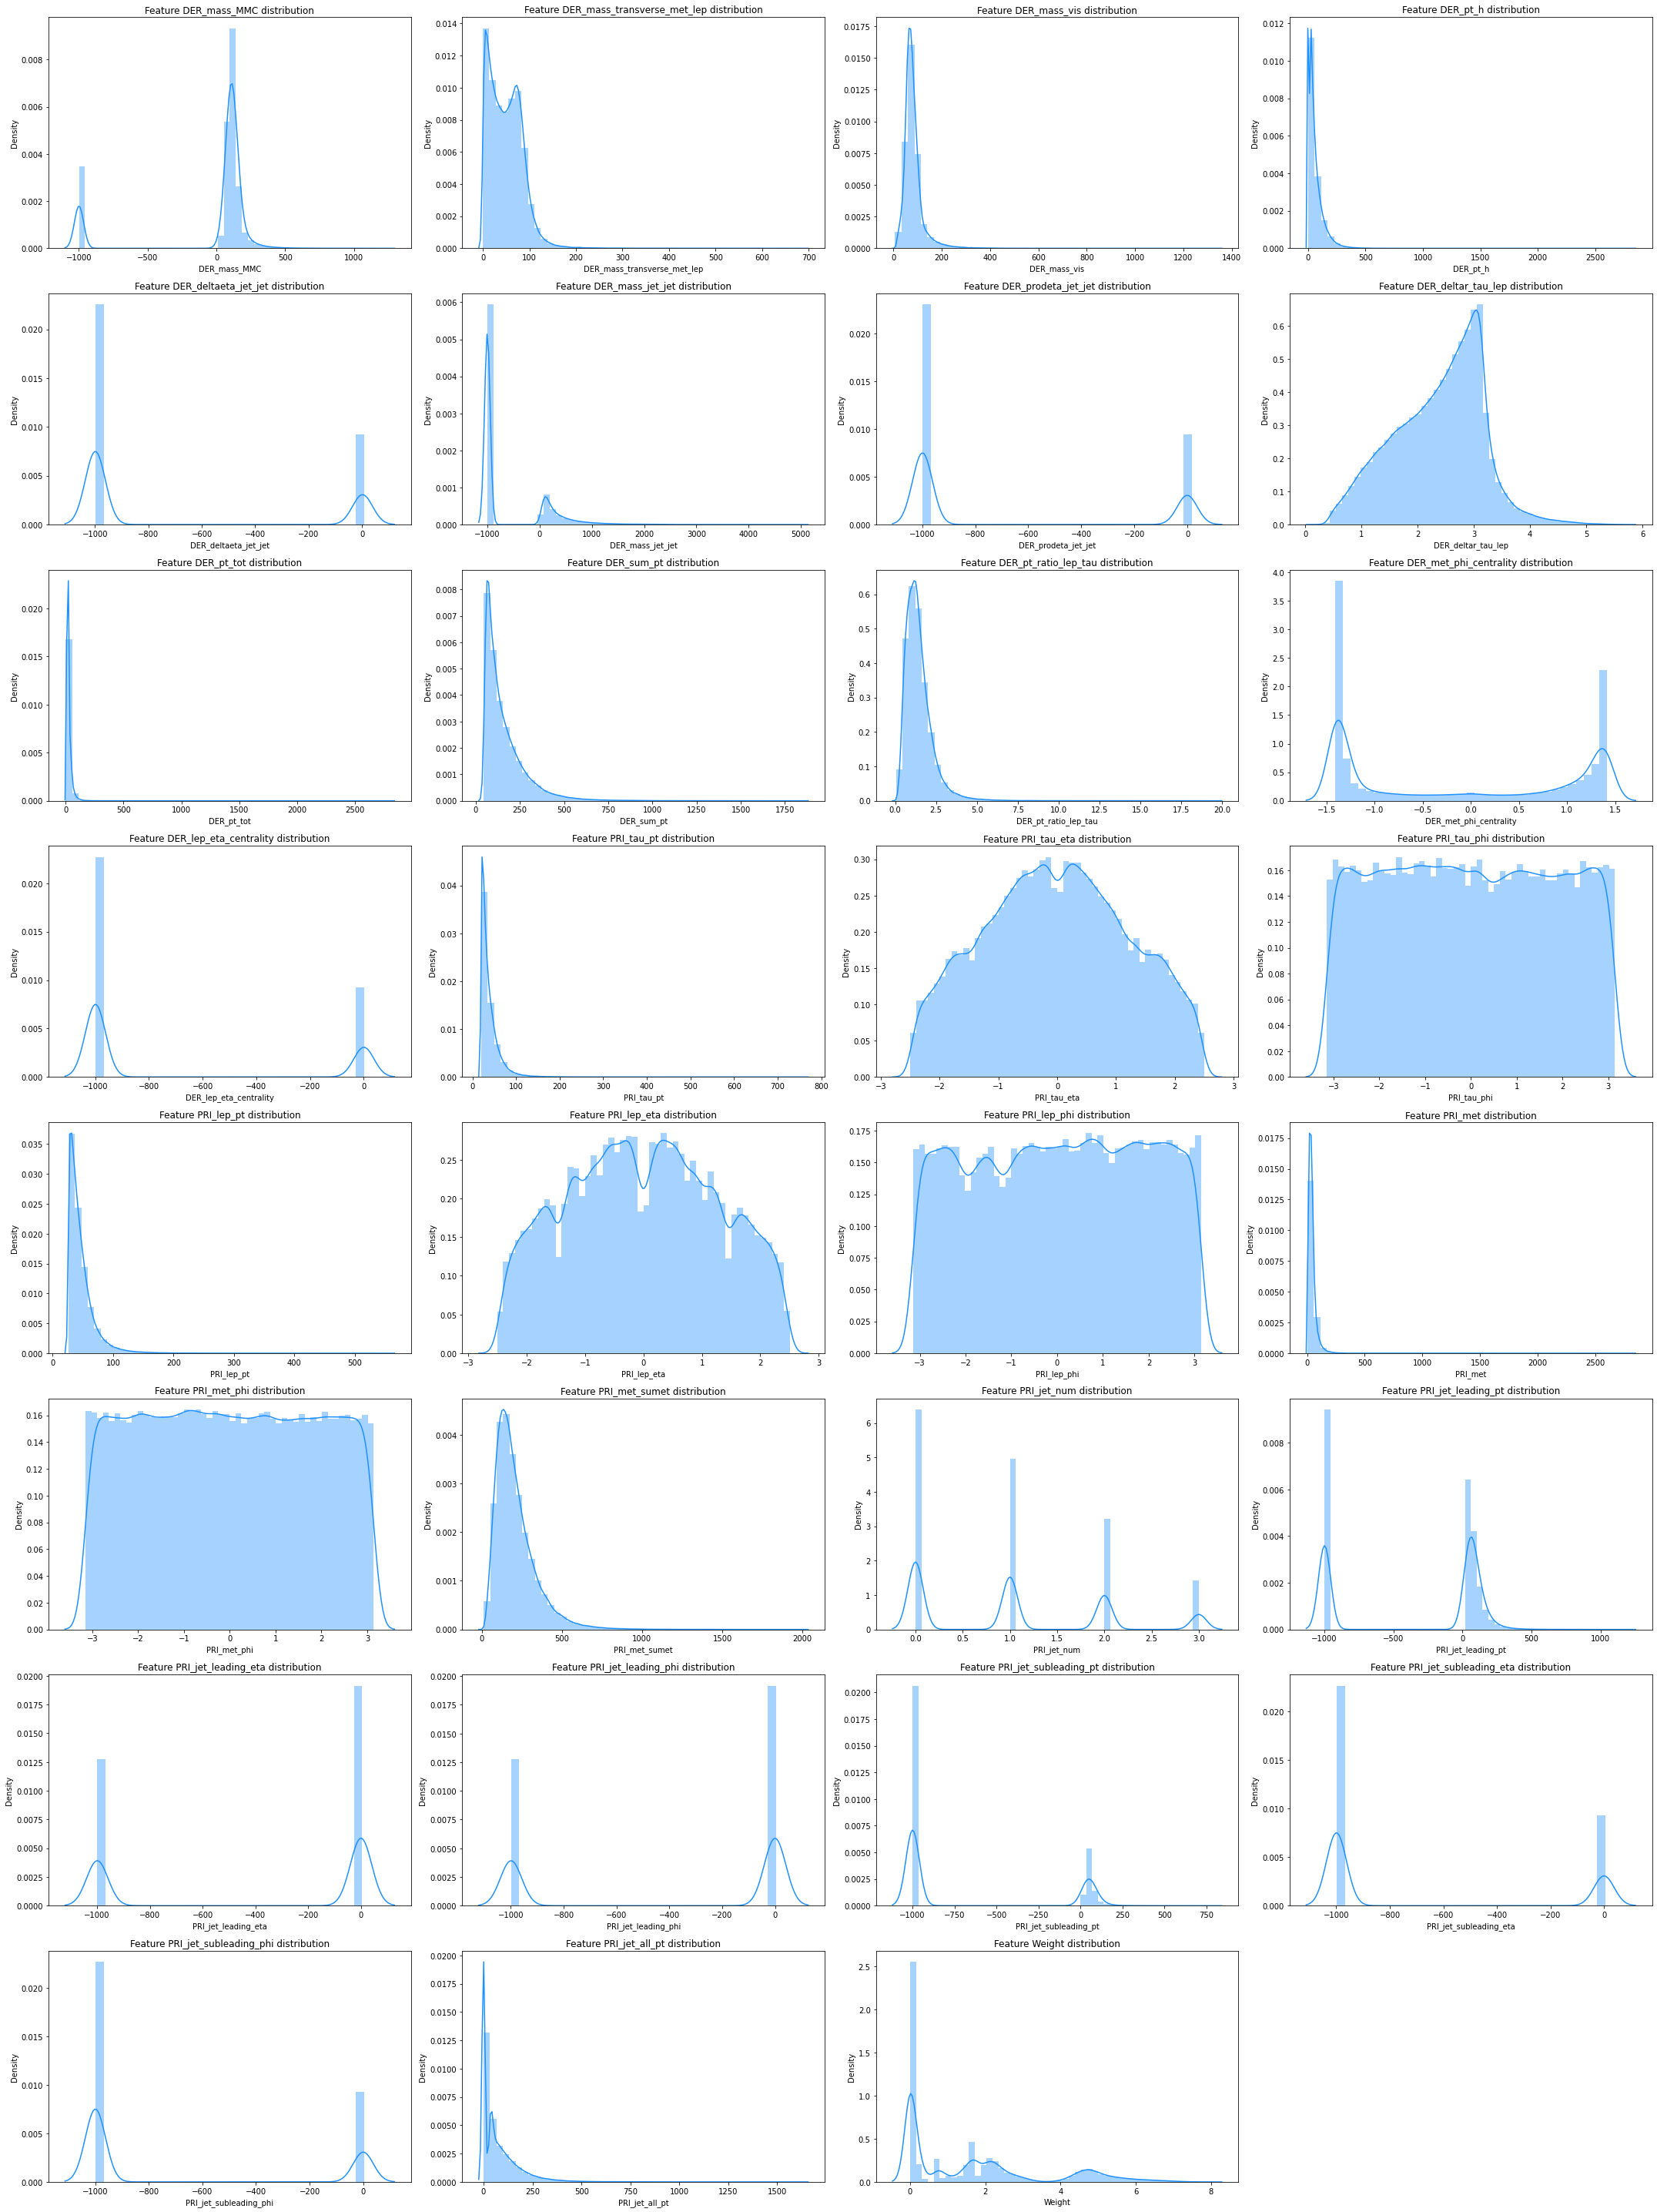

In [15]:
#Plotting Distribution of each feature
fig=plt.figure(figsize=(30,40))

for i in range(np.shape(train)[1]-1):
    ax = fig.add_subplot(8,4,i+1)
    ax = sns.distplot(train.iloc[:,i], color = 'dodgerblue')
    ax.set_title("Feature "+ train.columns[i] +" distribution")
fig.tight_layout();

## **Univariate Analysis**

### Finding the distribution of Data Per Class

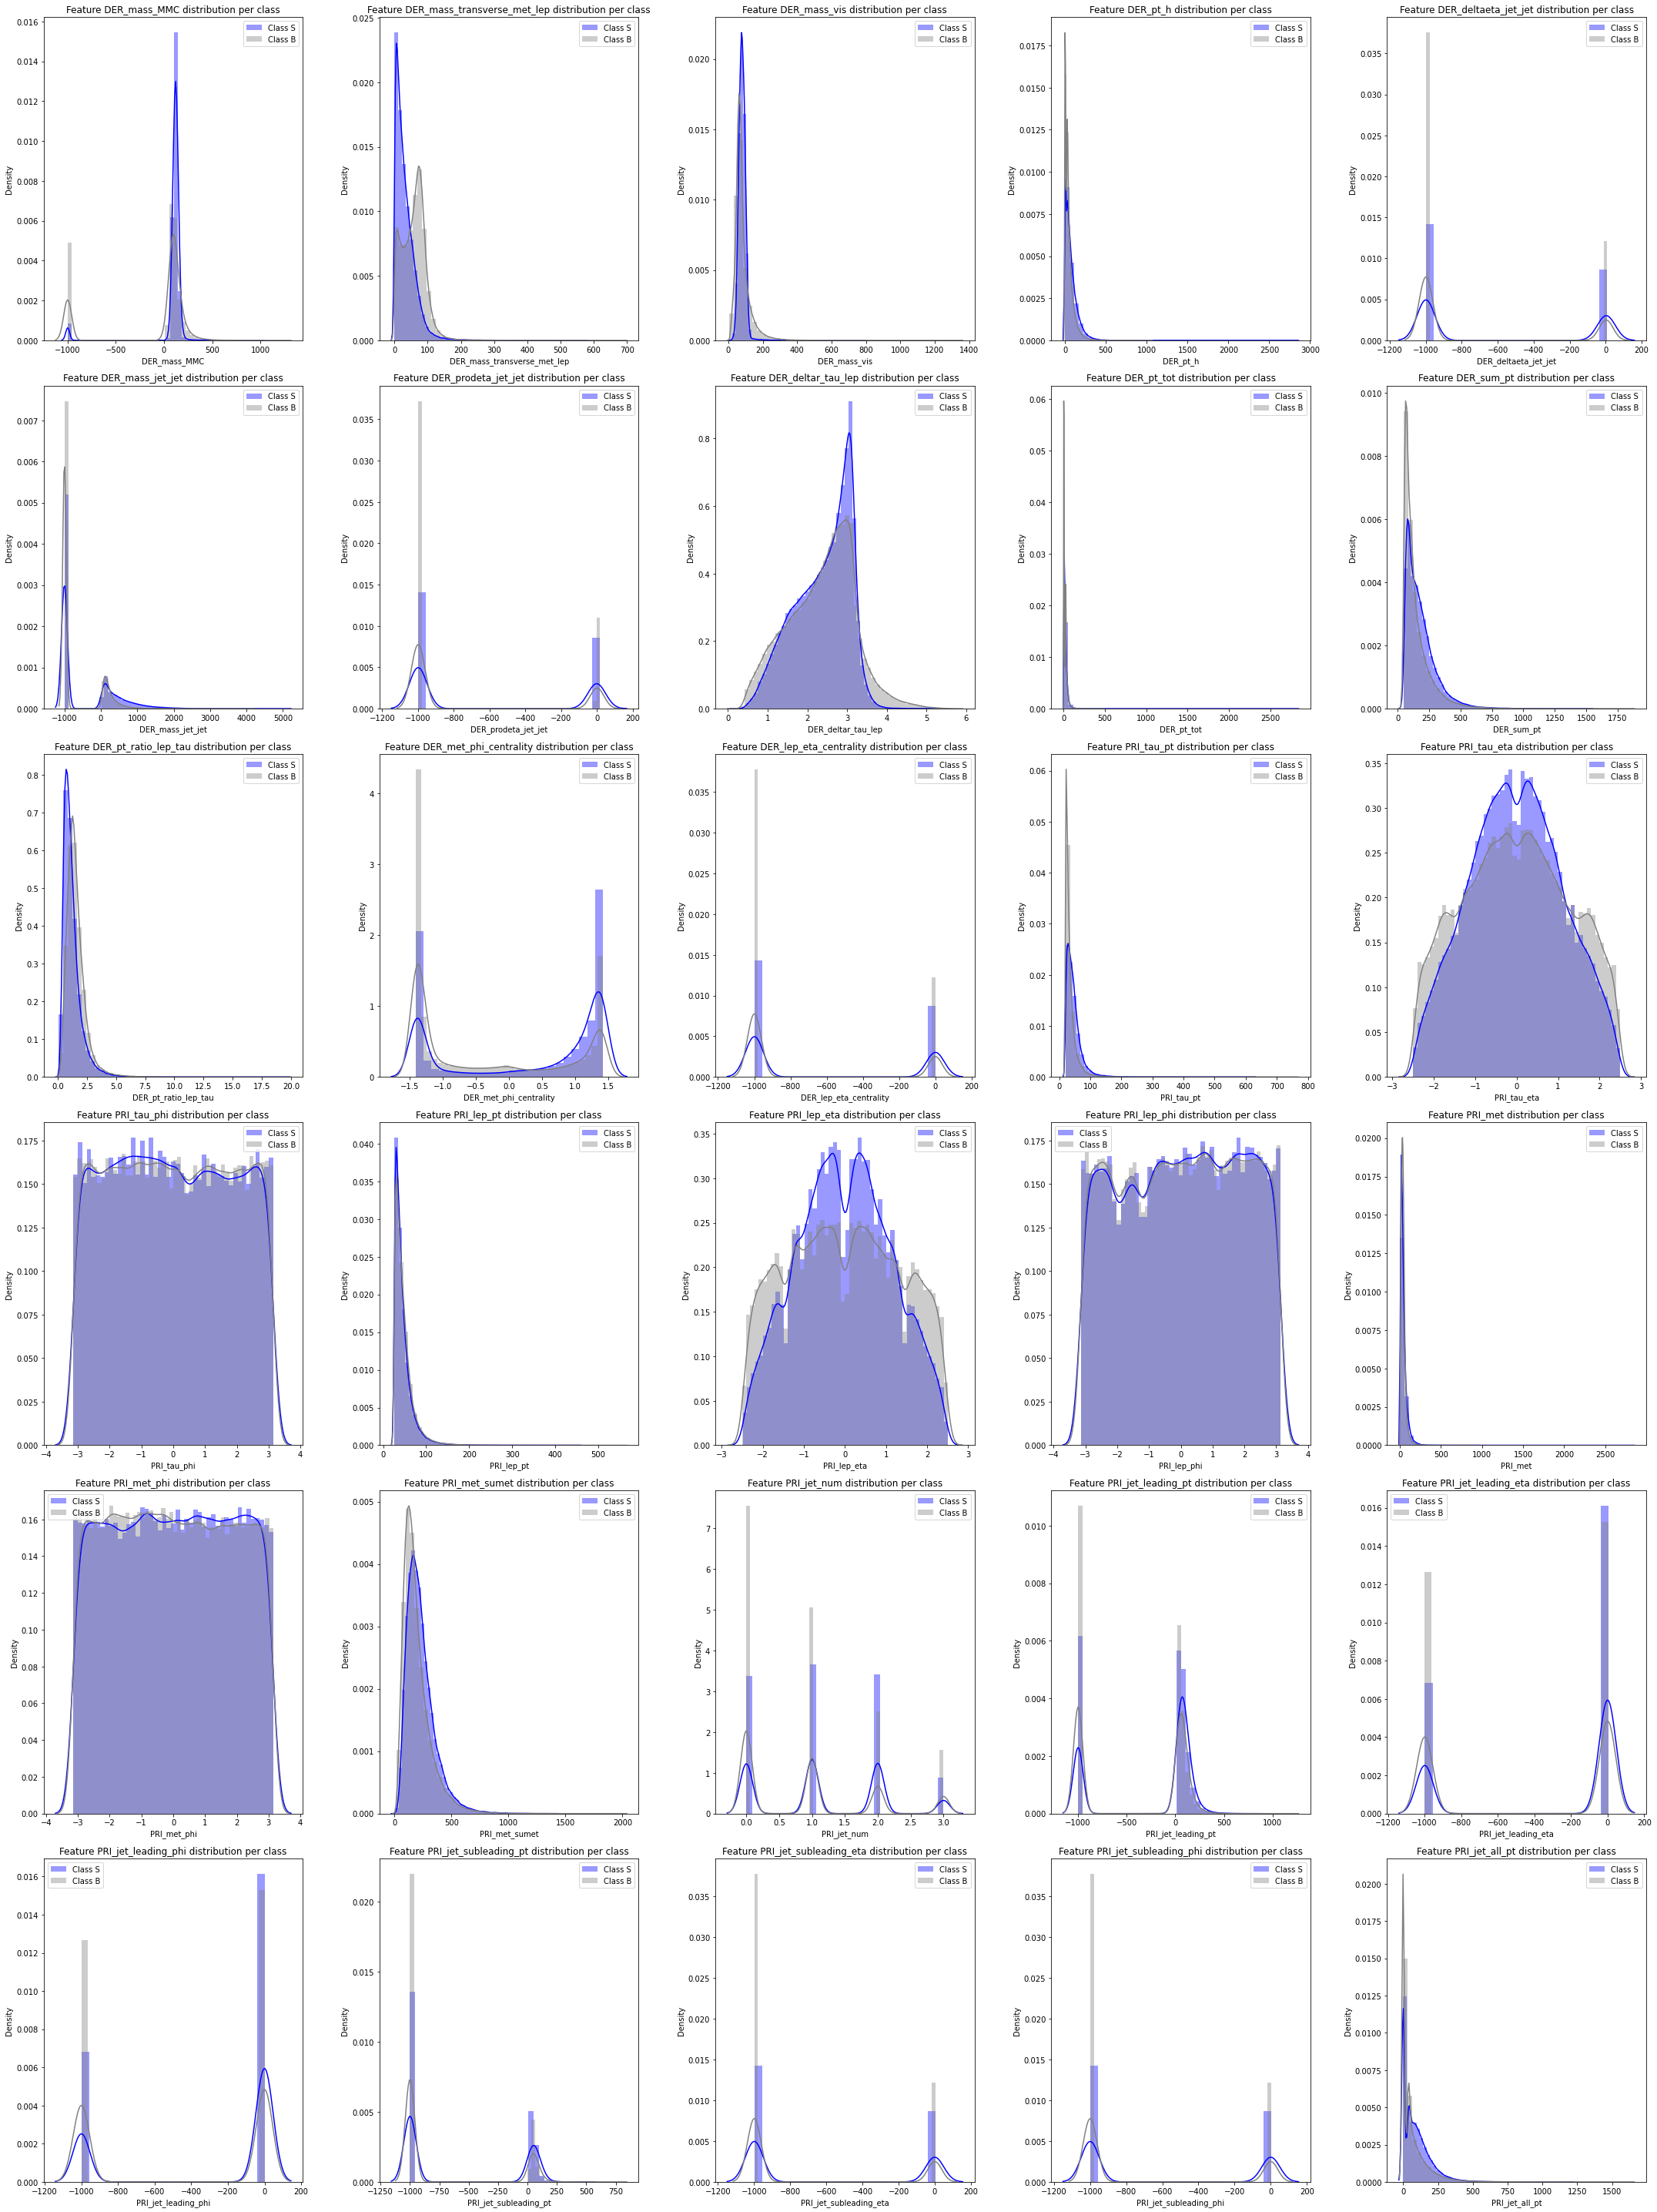

In [16]:
#Plotting Distribution of features per class
fig=plt.figure(figsize=(30,40))

for i in range(np.shape(train)[1]-2):
    ax = fig.add_subplot(6,5,i+1)
    ax = sns.distplot(train[train['Label'] == 's'].iloc[:,i],label="Class S", color = "blue")
    ax = sns.distplot(train[train['Label'] == 'b'].iloc[:,i],label="Class B", color = "grey")
    ax.set_title("Feature "+ train.columns[i] +" distribution per class")
    ax.legend()
fig.tight_layout();

## **Bivariate Analysis**

### Finding highly correlated Features - and printing the pairs of highly correlated features with threshold of 0.85

In [17]:
train.corr().style.background_gradient(cmap='Blues')

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
DER_mass_MMC,1.000000,-0.455755,0.168548,0.198765,0.162661,0.160524,0.162521,0.228105,0.045826,0.201464,-0.017073,0.358963,0.162623,0.131495,0.002579,-0.006177,0.099445,0.010060,-0.000744,-0.233724,0.007411,0.221984,0.221078,0.250158,0.247083,0.247078,0.162836,0.162614,0.162609,0.185372,-0.327244
DER_mass_transverse_met_lep,-0.455755,1.000000,0.190109,-0.249116,-0.176386,-0.190392,-0.175942,0.043251,0.017758,-0.146837,0.349504,-0.419757,-0.176262,-0.145464,-0.002109,0.001132,0.310648,-0.006777,0.000340,0.183716,-0.015925,-0.167811,-0.210537,-0.229674,-0.220370,-0.220355,-0.176837,-0.176231,-0.176225,-0.210009,0.419843
DER_mass_vis,0.168548,0.190109,1.000000,-0.062562,-0.032251,-0.040620,-0.032126,0.579712,-0.000702,0.088685,0.097490,-0.090846,-0.032220,0.290011,0.002127,-0.003624,0.405482,0.002196,-0.002018,-0.087330,-0.001467,0.053300,-0.026860,-0.019151,-0.013749,-0.013742,-0.033188,-0.032202,-0.032206,-0.052902,0.102172
DER_pt_h,0.198765,-0.249116,-0.062562,1.000000,0.523664,0.534531,0.523639,-0.539379,0.310501,0.832733,0.089187,0.539356,0.523720,0.407421,0.001665,0.005248,0.360939,0.008354,-0.002923,0.679585,0.008585,0.782547,0.623401,0.621599,0.564898,0.564894,0.531647,0.523714,0.523703,0.808616,-0.414084
DER_deltaeta_jet_jet,0.162661,-0.176386,-0.032251,0.523664,1.000000,0.946045,0.999981,-0.299076,0.270878,0.671996,0.041307,0.368492,0.999998,0.188086,0.004866,0.003302,0.168039,0.008678,0.000069,0.305561,0.005245,0.619100,0.867521,0.545027,0.521657,0.521664,0.999346,0.999995,0.999996,0.712446,-0.395375
DER_mass_jet_jet,0.160524,-0.190392,-0.040620,0.534531,0.946045,1.000000,0.944443,-0.303751,0.247771,0.680700,0.027674,0.369803,0.945584,0.204106,0.003584,0.003321,0.164026,0.007602,-0.000596,0.318497,0.005167,0.617057,0.814191,0.521645,0.493233,0.493241,0.947652,0.945505,0.945507,0.719962,-0.394004
DER_prodeta_jet_jet,0.162521,-0.175942,-0.032126,0.523639,0.999981,0.944443,1.000000,-0.299083,0.271435,0.672158,0.041614,0.368177,0.999990,0.187936,0.004880,0.003309,0.168270,0.008692,0.000070,0.305678,0.005254,0.619388,0.867741,0.545022,0.521653,0.521661,0.999347,0.999988,0.999989,0.712620,-0.395004
DER_deltar_tau_lep,0.228105,0.043251,0.579712,-0.539379,-0.299076,-0.303751,-0.299083,1.000000,-0.148081,-0.432603,0.047046,-0.205441,-0.299115,-0.202035,0.003632,-0.011229,-0.069957,0.000699,-0.000776,-0.402345,-0.001570,-0.407002,-0.347904,-0.335851,-0.304161,-0.304145,-0.303416,-0.299107,-0.299101,-0.448737,0.197881
DER_pt_tot,0.045826,0.017758,-0.000702,0.310501,0.270878,0.247771,0.271435,-0.148081,1.000000,0.381160,0.039193,0.178448,0.271058,0.095754,0.003596,0.001452,0.109617,0.007987,-0.004249,0.269739,0.002515,0.448925,0.360409,0.202920,0.186564,0.186590,0.279203,0.271100,0.271091,0.403382,-0.219507
DER_sum_pt,0.201464,-0.146837,0.088685,0.832733,0.671996,0.680700,0.672158,-0.432603,0.381160,1.000000,0.108791,0.420679,0.672116,0.485847,0.002037,0.003931,0.460938,0.008781,-0.001892,0.520129,0.006712,0.904481,0.758503,0.638796,0.578616,0.578621,0.687465,0.672125,0.672114,0.965628,-0.414827


### Printing out the highly correlated features along with their correlation

In [18]:
#List to store the features with high correlation as tuples
feat=[]
#Setting a threshold of 0.9 of correlation
threshold=0.9
correlation=X.corr()
for i in X.columns:
    temp=correlation[i]
    #Finding the correlated features greater than the threshold
    corr_features=temp[(abs(temp)>threshold) & (temp.index!=i)].index.values
    #Adding the correlated features into a list keeping in mind that there is only one occurrence of the feature combination
    if(len(corr_features)!=0):
        for j in corr_features:
            features=(i,j)
        
            if(len(feat)==0):
                feat.append(features)
            else:
                count=len(feat)
                for x in feat:
                    if set(x) != set(features):
                        count-=1  
                    else:
                        break
                if(count==0):
                    feat.append(features)
                #[feat.append(features) for x in feat if not (set(x)==set(features))]

In [19]:
print("The highly correlated features are given below")
for i in feat:
    corr=correlation[i[0]][i[1]]
    print('Features '+i[0]+' and '+i[1]+' are correlated with a correlation index of '+ str(np.round(corr,2)))

The highly correlated features are given below
Features DER_deltaeta_jet_jet and DER_mass_jet_jet are correlated with a correlation index of 0.95
Features DER_deltaeta_jet_jet and DER_prodeta_jet_jet are correlated with a correlation index of 1.0
Features DER_deltaeta_jet_jet and DER_lep_eta_centrality are correlated with a correlation index of 1.0
Features DER_deltaeta_jet_jet and PRI_jet_subleading_pt are correlated with a correlation index of 1.0
Features DER_deltaeta_jet_jet and PRI_jet_subleading_eta are correlated with a correlation index of 1.0
Features DER_deltaeta_jet_jet and PRI_jet_subleading_phi are correlated with a correlation index of 1.0
Features DER_mass_jet_jet and DER_prodeta_jet_jet are correlated with a correlation index of 0.94
Features DER_mass_jet_jet and DER_lep_eta_centrality are correlated with a correlation index of 0.95
Features DER_mass_jet_jet and PRI_jet_subleading_pt are correlated with a correlation index of 0.95
Features DER_mass_jet_jet and PRI_jet_s

## **Getting the Data Ready**

Since we have an imbalanced dataset, we are using SMOTE for upsampling and downsampling our dataset.

## A) Dropping Correlated Features

In [20]:
count = {}
for i, j in feat:
    if i in count.keys():
        count[i]+= 1
    else:
        count[i] = 1
    if j in count.keys():
        count[j]+= 1
    else:
        count[j] = 1
for k, v in count.items():
    if v > 2:
        X.drop(k, axis = 1, inplace = True)

In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250000 entries, 100000 to 349999
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   DER_mass_MMC                 250000 non-null  float64
 1   DER_mass_transverse_met_lep  250000 non-null  float64
 2   DER_mass_vis                 250000 non-null  float64
 3   DER_pt_h                     250000 non-null  float64
 4   DER_deltar_tau_lep           250000 non-null  float64
 5   DER_pt_tot                   250000 non-null  float64
 6   DER_sum_pt                   250000 non-null  float64
 7   DER_pt_ratio_lep_tau         250000 non-null  float64
 8   DER_met_phi_centrality       250000 non-null  float64
 9   PRI_tau_pt                   250000 non-null  float64
 10  PRI_tau_eta                  250000 non-null  float64
 11  PRI_tau_phi                  250000 non-null  float64
 12  PRI_lep_pt                   250000 non-null  float64

## B) SMOTE Technique

In [41]:
counter = Counter(y)
print('Before', counter)

smt = SMOTE()

#oversampling using SMOTE
X_sm, y_sm = smt.fit_resample(X,y)

counter = Counter(y_sm)
print('After', counter)

#Creating a Resampled Dataframe
X_sm_df = pd.DataFrame(X_sm, columns=X.columns)
y_sm_df = pd.DataFrame(y_sm, columns = ['Label'])

Before Counter({1: 164333, 0: 85667})
After Counter({0: 164333, 1: 164333})


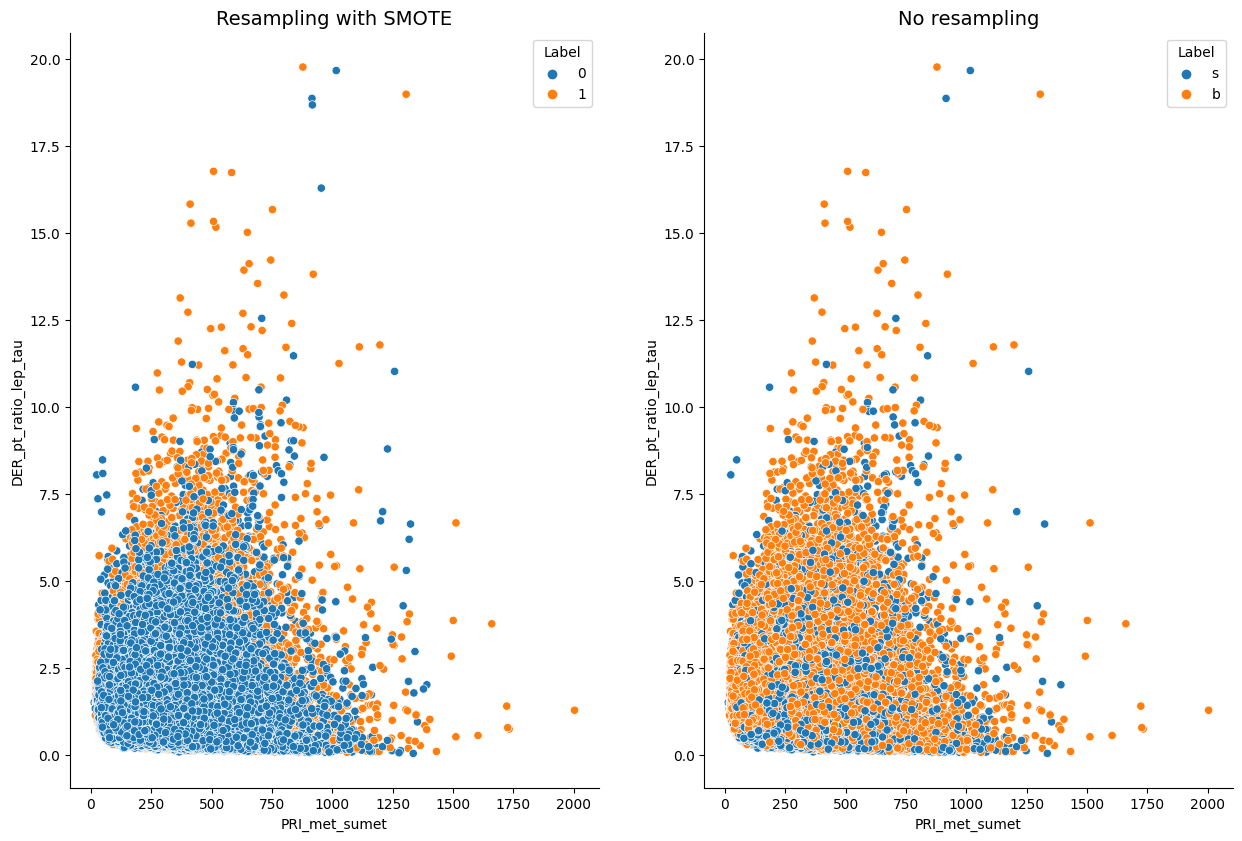

In [43]:
temp_df = pd.concat([X_sm_df,y_sm_df],axis=1)

f, axes = plt.subplots(figsize=(15, 10), dpi=100)
plt.subplot(121)
sns.despine()
sns.scatterplot(x=temp_df['PRI_met_sumet'], y=temp_df['DER_pt_ratio_lep_tau'], hue = temp_df['Label'], data=temp_df)
plt.title('Resampling with SMOTE', fontsize=14);

plt.subplot(122)
sns.despine()
sns.scatterplot(x=train['PRI_met_sumet'], y=train['DER_pt_ratio_lep_tau'], hue = train['Label'], data=train)
plt.title('No resampling', fontsize=14);

# **Creation of a Baseline Model**

In [22]:
#Storing Categorical and Continuous Variables
cat_vars = ['PRI_jet_num']
cont_vars = np.array(X.drop(['PRI_jet_num'],axis=1).columns)

## Utility Functions to make Model building and Cross-validation easier.

In [26]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None,oob_func=False):
    if ((not oob_func) and score_func):
        print("SCORE FUNC", score_func)
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    
    elif oob_func:
        print("OOB_Score")
        
        results = {}
        estimators= {}
        for n_est,mf,md in product(*parameters.values()):
            
            params = (n_est,mf,md)
            
            clf = RandomForestClassifier(random_state = 2017, n_estimators = n_est, max_features = mf, max_depth = md, oob_score=True, n_jobs = -1)
            
            clf.fit(X,y)
            
            results[params] = clf.oob_score_
            estimators[params] = clf
            
        outparams = max(results, key = results.get)
        
        print("Best Params: ",outparams)
        best_estimator = estimators[outparams]
        
        print("Training Score: ",best_estimator.score(X, y)) 
        print("OOB Score: ",best_estimator.oob_score_)
        
        return best_estimator

        
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
        
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_)
    best = gs.best_estimator_
    return best

def do_classify(clf, parameters, indf,y,score_func, n_folds=5, n_jobs=1,oob_func=False):
    X=indf
    y=y
    Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,train_size=0.8,random_state=2017)
    
    if oob_func:
        
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, oob_func=True)
        
    else:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    
    
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    
    print("########################################################")
    plot_confusion_matrix(clf,Xtest,ytest,cmap="Blues")
    return clf, Xtrain, ytrain, Xtest,ytest

def make_roc(name, clf, ytest, xtest, ax=None, labe=5,  proba=True, skip=0, initial = False):
    if not ax:
        ax=plt.gca()
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', lw=2, alpha=0.4, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', lw=2, alpha=0.4, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in range(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

def make_pr(name,clf,ytest,xtest,ax=None):
    
    scores = clf.predict_proba(xtest)[:,1]
    precision, recall, _ = precision_recall_curve(ytest, scores)
    
    ax.plot(recall,precision,'*-',label="Precision-Recall Curve for %s (area = %0.2f)" % (name,average_precision_score(ytest,scores)) )
    ax.set_xlim([-0.01,1.01])
    ax.set_ylim([-0.01,1.01])
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.grid()
    plt.tight_layout()
    plt.legend()
    return ax

def calibration_plot(name,clf, xtest, ytest):

    fig, ax = plt.subplots(2,1,figsize=(8,15))
    fop, mpv = calibration_curve(ytest,clf.predict_proba(xtest)[:,1], n_bins=20)
    count = 0
    ax[0].plot(mpv, fop, marker='*',label="Calibration curve for %s" %(name))
    ax[0].plot([0,1],[0,1])
    ax[1].hist(clf.predict_proba(xtest)[:, 1], range=(0, 1), bins=20)
    rect=ax[1].patches
    fig.legend()

def p_importance(model, cols, fi, fistd = 0):
    return pd.DataFrame({'features':cols, 'importance':fi, 'importance_std': fistd}
                       ).sort_values('importance', ascending=False)

def plot_perm_importance(name,model,Xtest,ytest,last=False,number=10):
    
    imp = permutation_importance(model,Xtest,ytest)

    xgf_df=p_importance(imp,Xtest.columns,imp['importances_mean'],imp['importances_std'])

    fig,ax=plt.subplots(figsize=(17,10))
    
    if last:
        sns.barplot(data=xgf_df[-number:],x='features',y='importance',label='%s_importances'%(name),ax=ax)
        
    else:
        sns.barplot(data=xgf_df[:number],x='features',y='importance',label='%s_importances'%(name),ax=ax)
    
    plt.xticks(rotation='45')
    plt.title("Bar plot of Importances for %s"%(name));
    
    return xgf_df


## Setting up Pipeline for Baseline Logistic Regression Model

SCORE FUNC roc_auc
BEST {'model__C': 10} 0.8051867220192221
############# based on standard predict ################
Accuracy on training data: 0.74
Accuracy on test data:     0.75
[[ 9214  7885]
 [ 4837 28064]]
########################################################


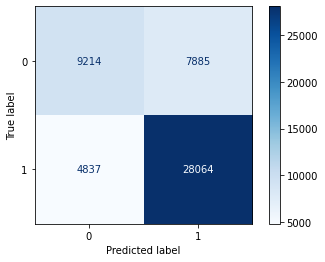

In [27]:
# set up standardization
ss = StandardScaler()

# oe hot encoding
oh = OneHotEncoder()

# continuous variables need to be standardized
cont_pipe = Pipeline([("scale", ss)])

# categorical variables need to be one hot encoded
cat_pipe = Pipeline([('onehot', oh)])

# combine both into a transformer
transformers = [('cont', cont_pipe, cont_vars), ('cat', cat_pipe, cat_vars)]

# apply transformer to relevant columns. Nothing will be done for the rest
ct = ColumnTransformer(transformers=transformers, remainder="passthrough")

# create a pipeline so that we are not leaking data from validation to train in the individual folds
pipe = Pipeline(steps=[('ct', ct), ('model', LogisticRegression(max_iter=10000, penalty='l2'))])

# in paramgrid we dont use C but use model__C corresponding to the name in the pipeline
paramgrid = dict(model__C=[1000, 100, 10])

#Now we train our model. Our do_classify takes care of subsetting the data and pickinging up the target variable.We score using the AUC on the validation sets.
lr, Xtrain, ytrain, Xtest, ytest = do_classify(pipe, paramgrid,X, y, score_func='roc_auc')

In [28]:
print(classification_report(ytest,lr.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.66      0.54      0.59     17099
           1       0.78      0.85      0.82     32901

    accuracy                           0.75     50000
   macro avg       0.72      0.70      0.70     50000
weighted avg       0.74      0.75      0.74     50000



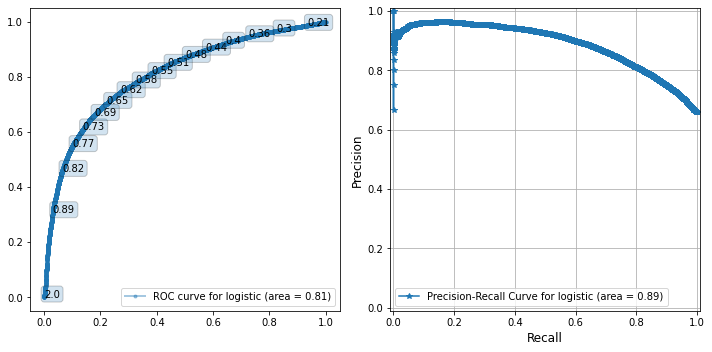

In [37]:
fig,ax=plt.subplots(1,2,figsize=(10,5))

make_roc('logistic', lr, ytest , Xtest, ax=ax[0],labe=1000, initial = False)
make_pr('logistic', lr, ytest, Xtest,ax=ax[1]);

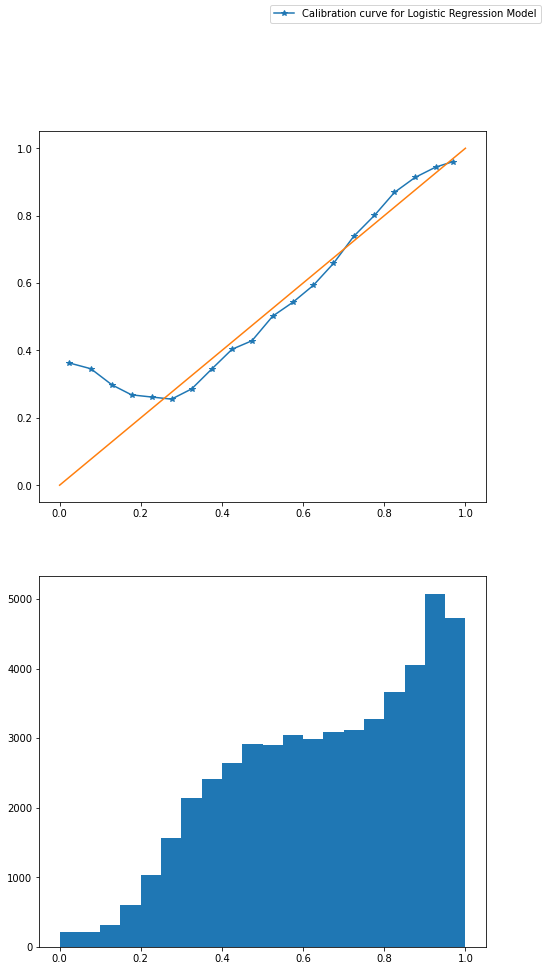

In [39]:
 calibration_plot("Logistic Regression Model",lr, Xtest, ytest)

## Setting up Pipeline for Random Forest Classifier

In [ ]:
# Create a pipeline so that we are not leaking data from validation to train in the individual folds
rf = RandomForestClassifier()
paramgrid_rf = { 'max_features': ['auto', 'sqrt'],
  'max_depth': [5,10, 20, None], 
  'min_samples_split': [2, 5, 10], 
  'min_samples_leaf': [1, 2, 4],
  'bootstrap': [True, False]}

rf, Xtrain, ytrain, Xtest, ytest = do_classify(rf, paramgrid_rf, X_sm, y_sm, score_func='roc_auc')

SCORE FUNC roc_auc


## Setting up Pipeline for Decision Tree Classifier

SCORE FUNC roc_auc
BEST {'dt__criterion': 'gini', 'dt__max_depth': 8, 'dt__min_samples_leaf': 4} 0.8465906797665423


############# Based On Standard Predict ################
Accuracy on training data: 0.80
Accuracy on test data:     0.78

[[28825  4069]
 [ 6739 10367]]
########################################################



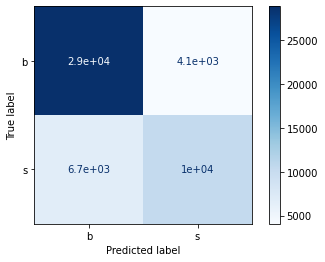

In [57]:
# Create a pipeline so that we are not leaking data from validation to train in the individual folds
dt = DecisionTreeClassifier(random_state=142)
paramgrid_dt = {'max_depth':range(1,9),'min_samples_leaf':range(3,5),'criterion':['gini']}

clf, Xtrain, ytrain, Xtest,ytest = do_classify(dt, paramgrid_dt,X_sm,y_sm,'roc_auc',n_folds=5,n_jobs=-1)

In [ ]:
print(classification_report(ytest,dt.predict(Xtest)))

In [58]:
colors = [None, None,['red','blue'],]
dt_viz = dtreeviz(DecisionTreeClassifier(random_state=142), X_sm,y_sm,
               feature_names = X_sm.columns,
               target_name = 'Label', class_names= ['S','B'],orientation = 'TD',
               colors={'classes':colors},
               label_fontsize=12,
               ticks_fontsize=10,
               )

dt_viz.save("DecisionTreeClassifier.svg")

dt_viz

AttributeError: ignored

In [ ]:
dimp = permutation_importance(DecisionTreeClassifier(random_state=142),Xtest,ytest)
ddf = p_importance(DecisionTreeClassifier(random_state=142),list(X.columns),dimp['importances_mean'],dimp['importances_std']).iloc[:10]

fig,ax=plt.subplots(figsize=(17,10))
sns.barplot(data=ddf,x='features',y='importance',label='Decision_importances',ax=ax)
plt.xticks(rotation='45')
plt.title("Bar plot of Importances for Decision Tree Model");

## Trying out Boosting Models

In [ ]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X , y ,train_size=0.8)

dtrain = xgb.DMatrix(Xtrain, label=ytrain)
dvalid = xgb.DMatrix(Xtest, label=ytest)

xgb_pars = {'min_child_weight': 100, 
            'eta': 0.04, 
            'colsample_bytree': 0.8, 
            'max_depth': 100,
            'subsample': 0.75, 
            'lambda': 2, 
            'nthread': -1, 
            'booster' : 
            'gbtree', 
            'silent': 1, 
            'gamma' : 0,
            'eval_metric': 'mae', 
            'objective': 'reg:linear'}    

boost = xgb.train(xgb_pars, dtrain, 500, maximize=False, verbose_eval=15) 

y_pred = clf3.predict(dvalid)
y_pred = [1 if y>0.5 else 0 for y in y_pred]

print(classification_report(ytest,y_pred))


## **Plotting and Comparing ROC Curves**

In [ ]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5,  proba=True, skip=0, initial = False):
    if not ax:
        ax=plt.gca()
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', lw=2, alpha=0.4, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', lw=2, alpha=0.4, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in range(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

In [ ]:
make_roc('logistic', lr, ytest ,xtest, ax=ax, labe=10,  proba=True, skip=16300, initial = False)

In [ ]:
make_roc('randomForest', rf,ytest ,Xtest, ax=ax, labe=10,  proba=True, skip=16300, initial = False)

In [ ]:
make_roc('decisionTree', dt,ytest ,Xtest, ax=ax, labe=10,  proba=True, skip=16300, initial = False)

In [ ]:
make_roc('xgbboost', boost,ytest ,Xtest, ax=ax, labe=10,  proba=True, skip=16300, initial = False)

## **Self-supervised learning in Tabular Domain using VIME**

In [63]:
#Setting Initial hyperparameters
# Experimental parameters
label_no = 1000  
model_sets = ['logit','xgboost','mlp']
  
# Hyper-parameters
p_m = 0.3
alpha = 0.01
K = 4
beta = 1.0
label_data_rate = 0.6

# Metric
metric = 'acc'
  
# Define output
results = np.zeros([len(model_sets)+2])  

In [64]:
#Scaling data
scaler = StandardScaler()
X_sm = scaler.fit_transform(X_sm)

#Encoding Data
y_sm = np.where(y_sm == 'b',1,0)

### Splitting into unlabelled data and defining Utility functions

In [66]:
#Splitting X and y into train and test 
x_train_, x_test_, y_train_, y_test_ = train_test_split(X_sm, y_sm, train_size=0.7, random_state=123)

#Spillting into unlabelled and labelled
idx = np.random.permutation(len(y_train_))

# Label data : Unlabeled data = label_data_rate:(1-label_data_rate)
label_idx = idx[:int(len(idx)*label_data_rate)]
unlab_idx = idx[int(len(idx)*label_data_rate):]

# Unlabeled data
x_unlab = x_train_.iloc[unlab_idx, :]

# Labeled data
x_train = x_train_.iloc[label_idx, :]  
y_train = y_train_[label_idx, :]

TypeError: ignored

### Defining our Mask Generator
![image.png](attachment:image.png)


In [62]:
#Mask Generator
def mask_generator (p_m, x):
    mask = np.random.binomial(1, p_m, x.shape)
    return mask

## Defining our Pre-text Generator

In [ ]:
#Pre-text Generator
def pretext_generator (m, x):  
    """Generate corrupted samples.

    Args:
    m: mask matrix
    x: feature matrix

    Returns:
    m_new: final mask matrix after corruption
    x_tilde: corrupted feature matrix
    """

    # Parameters
    no, dim = x.shape  
    
    # Randomly (and column-wise) shuffle data
    x_bar = np.zeros([no, dim])
    
    for i in range(dim):
        idx = np.random.permutation(no)
        x_bar[:, i] = x.iloc[idx, i]

    # Corrupt samples
    x_tilde = x * (1-m) + x_bar * m  
    
    # Define new mask matrix
    m_new = 1 * (x != x_tilde)

    return m_new, x_tilde

In [ ]:
#MLP
def mlp(x_train, y_train, x_test, parameters): 

    # Convert labels into proper format
    if len(y_train.shape) == 1:
        no = len(y_train)
        dim = len(np.unique(y_train))

        # Define output
        matrix = np.zeros([no,dim])

        # Convert vector to matrix
        for i in range(dim):
            idx = np.where(y_train == i)
            matrix[idx, i] = 1

        y_train = matrix

    # Divide training and validation sets (9:1)
    idx = np.random.permutation(len(x_train[:, 0]))
    train_idx = idx[:int(len(idx)*0.9)]
    valid_idx = idx[int(len(idx)*0.9):]

    # Validation set
    x_valid = x_train[valid_idx, :]
    y_valid = y_train[valid_idx, :]

    # Training set
    x_train = x_train[train_idx, :]
    y_train = y_train[train_idx, :]  

    # Define network parameters
    hidden_dim = parameters['hidden_dim']
    epochs_size = parameters['epochs']
    act_fn = parameters['activation']
    batch_size = parameters['batch_size']

    # Define basic parameters
    data_dim = len(x_train[0, :])
    label_dim = len(y_train[0, :])

    # Build model
    model = Sequential()
    model.add(Dense(hidden_dim, input_dim = data_dim, activation = act_fn))
    model.add(Dense(hidden_dim, activation = act_fn))
    model.add(Dense(hidden_dim, activation = act_fn))
    model.add(Dense(hidden_dim, activation = act_fn))
    model.add(Dense(label_dim, activation = 'sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer='adam', 
                metrics = ['acc'])

    es = EarlyStopping(monitor='val_loss', mode = 'min', 
                     verbose = 1, restore_best_weights=True, patience=50)

    # Fit model on training dataset
    history = model.fit(x_train, y_train, validation_data = (x_valid, y_valid), 
            epochs = epochs_size, batch_size = batch_size, 
            verbose = 0, callbacks=[es])

    # Predict on x_test
    y_test_hat = model.predict(x_test)
    
    # evaluate model
    _, acc = model.evaluate(x_test, y_test, verbose=0)
    
    return y_test_hat, history, acc

In [ ]:
#Encoder

# Parameters
_, dim = x_unlab.shape
epochs = 30
batch_size = 128

# Build model  
inputs = Input(shape=(dim,))

# Encoder  
h = Dense(int(dim), activation='relu')(inputs)  

# Mask estimator
output_1 = Dense(dim, activation='sigmoid', name = 'mask')(h)  

# Feature estimator
output_2 = Dense(dim, activation='sigmoid', name = 'feature')(h)

model = Model(inputs = inputs, outputs = [output_1, output_2])

model.compile(optimizer='adam',
            loss={'mask': 'binary_crossentropy', 
                  'feature': 'mean_squared_error'},
            loss_weights={'mask':1, 'feature':alpha})

# Generate corrupted samples
m_unlab = mask_generator(p_m, x_unlab)
m_label, x_tilde = pretext_generator(m_unlab, x_unlab)

# Fit model on unlabeled data
encoder_history = model.fit(x_tilde, {'mask': m_label, 'feature': x_unlab}, 
        epochs = epochs, batch_size= batch_size)

# Extract encoder part
layer_name = model.layers[1].name
layer_output = model.get_layer(layer_name).output
encoder = models.Model(inputs=model.input, outputs=layer_output)

In [ ]:
plt.figure(figsize=(18,7))
# plot loss
plt.title('Mask Loss')
plt.plot(encoder_history.history['mask_loss'], color='orange', label='Mask Loss')
plt.plot(encoder_history.history['feature_loss'], color='red', label='Feature Loss')
plt.legend();

In [ ]:
mlp_parameters = dict()
mlp_parameters['hidden_dim'] = 256
mlp_parameters['epochs'] = 1000
mlp_parameters['activation'] = 'sigmoid'
mlp_parameters['batch_size'] = 128

x_train_hat = encoder.predict(x_train)
x_test_hat = encoder.predict(x_test)
      
y_test_hat, MLP_history, acc = mlp(x_train_hat, y_train, x_test_hat, mlp_parameters)

print('VIME-Self Accuracy: ' + str(np.round(acc,2)))

In [ ]:
plt.figure(figsize=(18,7))
# plot loss
plt.subplot(121)
plt.title('Cross Entropy Loss')
plt.plot(MLP_history.history['loss'], color='blue', label='train')
plt.plot(MLP_history.history['val_loss'], color='orange', label='test')
plt.legend()

# plot accuracy
plt.subplot(122)
plt.title('Classification Accuracy')
plt.plot(MLP_history.history['acc'], color='blue', label='train')
plt.plot(MLP_history.history['val_acc'], color='orange', label='test')
plt.legend();